In [1]:
!pip install numerapi
!pip install numerai-tools
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 34.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.1.4, but you have pandas 2.1.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 15.8 MB/s eta 0:00:00


In [16]:
from numerapi import NumerAPI
from numerai_tools.scoring import numerai_corr, correlation_contribution

import pandas as pd
import json

import matplotlib.pyplot as plt

import lightgbm as lgb

api = NumerAPI()

## Download v4.3 data

In [53]:
VERSION = 4.3
datasets = [dataset for dataset in api.list_datasets() if (dataset.startswith(f'v{VERSION}')) & ~("example" in dataset)]
datasets

['v4.3/features.json',
 'v4.3/live_benchmark_models.parquet',
 'v4.3/live_int8.parquet',
 'v4.3/meta_model.parquet',
 'v4.3/train_benchmark_models.parquet',
 'v4.3/train_int8.parquet',
 'v4.3/validation_benchmark_models.parquet',
 'v4.3/validation_int8.parquet']

In [54]:
%%time
for dataset in datasets:
  api.download_dataset(dataset)

v4.3/features.json: 1.12MB [00:00, 5.29MB/s]                          
v4.3/live_benchmark_models.parquet: 1.58MB [00:00, 6.41MB/s]                            
v4.3/live_int8.parquet: 6.60MB [00:00, 17.0MB/s]                            
v4.3/meta_model.parquet: 28.6MB [00:00, 28.7MB/s]                            
v4.3/train_benchmark_models.parquet: 563MB [00:22, 24.8MB/s]                           
v4.3/train_int8.parquet: 2.10GB [01:16, 27.4MB/s]                            
v4.3/validation_benchmark_models.parquet: 878MB [00:35, 24.9MB/s]                           
v4.3/validation_int8.parquet: 2.62GB [01:57, 22.3MB/s]                            

CPU times: user 55.3 s, sys: 11.7 s, total: 1min 6s
Wall time: 4min 18s


## Read data

In [61]:
feature_metadata = json.load(open("v4.3/features.json"))
for f_set in feature_metadata["feature_sets"]:
  print(f"{f_set} : {len(feature_metadata['feature_sets'][f_set])}")

small : 42
medium : 705
all : 2376
v2_equivalent_features : 304
v3_equivalent_features : 1000
fncv3_features : 400
intelligence : 35
charisma : 290
strength : 135
dexterity : 51
constitution : 335
wisdom : 140
agility : 145
serenity : 95
sunshine : 325
rain : 666
midnight : 244


In [62]:
feature_set = feature_metadata["feature_sets"]["medium"]

In [63]:
%%time
train = pd.read_parquet("v4.3/train_int8.parquet", columns=["era", "target"] + feature_set)
train.era = train.era.astype(int)
# downsample to non-overlapping eras for d20 targets
train = train[train["era"].isin(train["era"].unique()[::4])]

validation = pd.read_parquet("v4.3/validation_int8.parquet", columns=["era", "target", "data_type"] + feature_set)
validation.era = validation.era.astype(int)
validation = validation.loc[validation["data_type"]=="validation"]
validation.drop("data_type", axis=1, inplace=True)
# downsample to non-overlapping eras for d20 targets
validation = validation[validation["era"].isin(validation["era"].unique()[::4])]

CPU times: user 44.1 s, sys: 33.2 s, total: 1min 17s
Wall time: 8.18 s


## Train a model

In [64]:
model = lgb.LGBMRegressor(
  verbose=0,
  n_estimators=2000,
  learning_rate=0.01,
  max_depth=5,
  num_leaves=2**5-1,
  colsample_bytree=0.1
)

model.fit(
  train[feature_set],
  train["target"]
)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor(colsample_bytree=0.1, learning_rate=0.01, max_depth=5,
              n_estimators=2000, verbose=0)

### Evaluate on validation set

In [70]:
last_train_era = int(train["era"].unique()[-1])
eras_to_embargo = [era for era in [last_train_era + i for i in range(4)]]
validation = validation[~validation["era"].isin(eras_to_embargo)]

validation["prediction"] = model.predict(validation[feature_set])

per_era_corr = validation.groupby("era").apply(lambda x: numerai_corr(x[["prediction"]].dropna(), x["target"].dropna()))

# Compute performance metrics
corr_mean = per_era_corr.mean()
corr_std = per_era_corr.std(ddof=0)
corr_sharpe = corr_mean / corr_std
corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

print("corr_mean", corr_mean.values[0])
print("corr_std", corr_std.values[0])
print("corr_sharpe", corr_sharpe.values[0])
print("corr_max_drawdown", corr_max_drawdown.values[0])

corr_mean 0.02449115575739677
corr_std 0.02142577569537585
corr_sharpe 1.1430697355187236
corr_max_drawdown 0.06369478241452153


<Axes: title={'center': 'Cumulative Validation CORR'}, xlabel='era'>

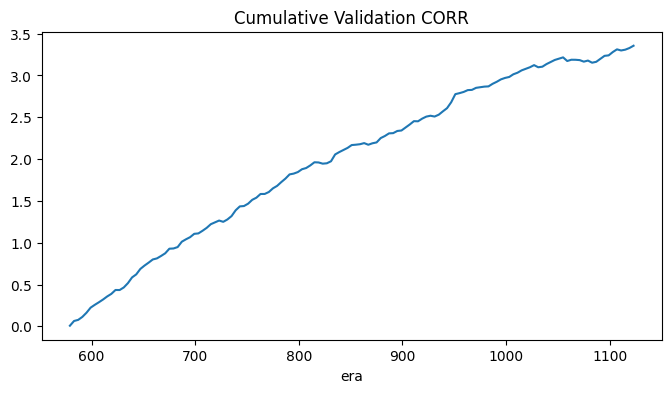

In [71]:
per_era_corr.cumsum().plot(
  title="Cumulative Validation CORR",
  kind="line",
  figsize=(8, 4),
  legend=False
)

### Evaluate in train set

In [66]:
train["prediction"] = model.predict(train[feature_set])

per_era_corr = train.groupby("era").apply(lambda x: numerai_corr(x[["prediction"]].dropna(), x["target"].dropna()))

# Compute performance metrics
corr_mean = per_era_corr.mean()
corr_std = per_era_corr.std(ddof=0)
corr_sharpe = corr_mean / corr_std
corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

print("corr_mean", corr_mean.values[0])
print("corr_std", corr_std.values[0])
print("corr_sharpe", corr_sharpe.values[0])
print("corr_max_drawdown", corr_max_drawdown.values[0])

corr_mean 0.21408010487768867
corr_std 0.023484089559374085
corr_sharpe 9.115963569140574
corr_max_drawdown 0.0


## Live predictions

In [74]:
live_features = pd.read_parquet(f"v4.3/live_int8.parquet", columns=feature_set)

live_predictions = model.predict(live_features[feature_set])

pd.Series(live_predictions, index=live_features.index).to_frame("prediction").to_csv("submission.csv")

## Pickle the model

In [75]:
import cloudpickle

def predict(live_features: pd.DataFrame) -> pd.DataFrame:
  live_predictions = model.predict(live_features[feature_set])
  submission = pd.Series(live_predictions, index=live_features.index)
  return submission.to_frame("prediction")

p = cloudpickle.dumps(predict)
with open("predict.pkl", "wb") as f:
    f.write(p)